In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

In [ ]:
from sklearn import linear_model, svm, preprocessing, decomposition
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Here we construct separate classification models to predict:

- high blood pressure ( systolic > 132 mm/Hg or diastolic > 92 mm/Hg)  
- high cholesterol ( total cholesterol > 236 mg/dL)  
- diabetes ( glycohemoglobin > 5.9% )

In [ ]:
# import XY dataset from csv produced in data_extract_clean_recode notebook:
XY = pd.read_csv('NHANES_XY.csv')

## Establish a pipeline to streamline:

- feature selection/scaling
- missing value imputation/filtering  
- and model testing/evaluation on class-balanced datasets:

In [228]:
# filter here for any parameters you like, e.g. by age, or by year of study (using .index (SEQN ID values) as cutoff)
XY = XY[XY.RIDAGEYR < 70]
XY = XY[XY.RIDAGEYR > 18]

# if filtering, drop any columns that don't contain values (e.g. if only looking at data from pre 2001, 
# you'll want to drop all questions that weren't asked in those years)
for each in list(XY):
    if str(XY[each].min()) == 'nan':
        XY = XY.drop(each, axis=1)
        print ('dropping ', each)

In [72]:
# here we can filter based on the quantity of NaNs per subject.  if a patient only answered 10% of the questions
# we're looking to use, we can drop those individuals
todrop = []
for i in range(XY.shape[0]):
    mylist = XY.iloc[i,:].value_counts(dropna=False)
    if np.nan in (mylist.index):
        if mylist[np.nan] > 35.0:    # the max number of NaNs we're willing to tolerate
            todrop.append(XY.index[i])
print ('Dropping ', len(todrop), 'subjects')
for each in todrop:
    XY = XY.drop(each, axis=0)

Dropping  287 subjects


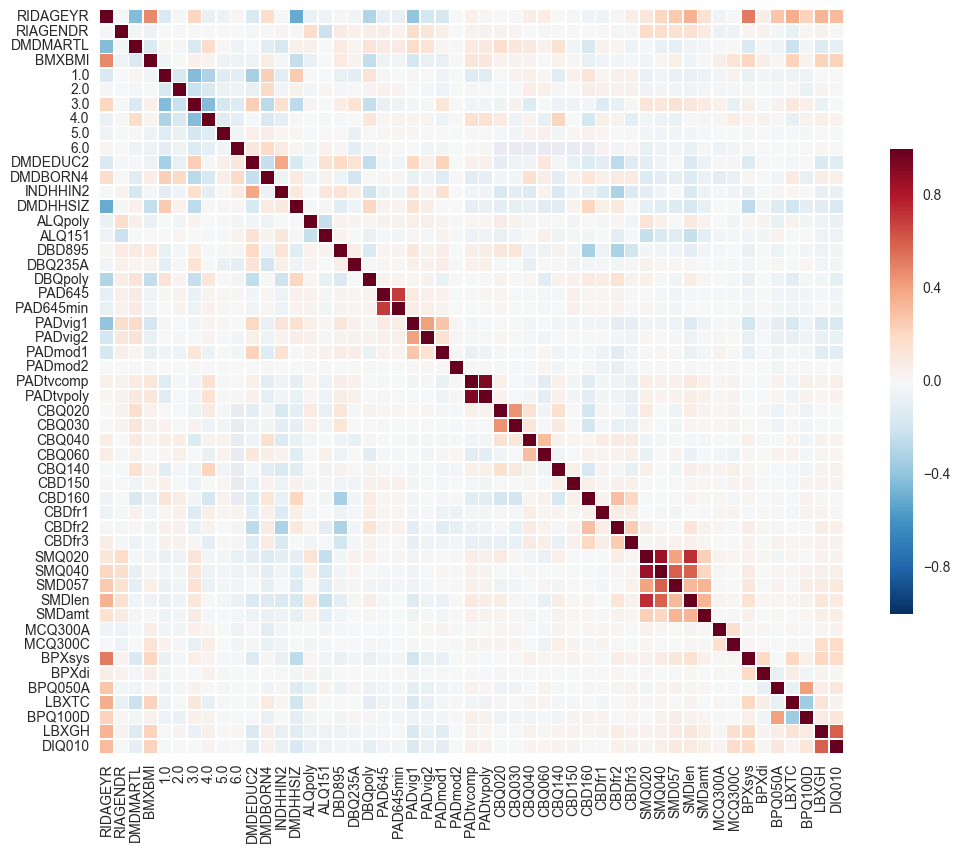

In [538]:
# plot the feature correlation for the features in our XY table.
corr = XY.corr(); mask = np.zeros_like(corr, dtype=np.bool); mask[np.triu_indices_from(mask)] = True
plt.rcParams['figure.figsize']=(12,12)
g=sns.heatmap(corr, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [235]:
# Hand select features to build a model from, and check the # of NaNs for each feature
XY = XY[['RIDAGEYR', 'RIAGENDR', 'DMDMARTL', 'BMXBMI', 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 'DMDEDUC2', 'INDHHIN2', 'DMDHHSIZ', 'DBD895', 'DBD900', 'PADvig2', 'PADmod2', 'PADtvcomp', 'SMQ020', 'SMDlen', 'SMDamt', 'ALQpoly', 'MCQ300A', 'MCQ300C', 'BPXsys', 'BPXdi', 'BPQ050A', 'LBXTC', 'BPQ100D', 'LBXGH', 'DIQ010']]
XY.isnull().sum()

RIDAGEYR         0
RIAGENDR         0
DMDMARTL     31856
BMXBMI       20108
1.0              0
2.0              0
3.0              0
4.0              0
5.0              0
6.0              0
DMDEDUC2     38400
INDHHIN2      5569
DMDHHSIZ         0
DBD895        4214
DBD900       38593
PADvig2      24186
PADmod2      28559
PADtvcomp    34871
SMQ020       38010
SMDlen       38184
SMDamt       38010
ALQpoly      49554
MCQ300A      39820
MCQ300C      39250
BPXsys       23512
BPXdi        23512
BPQ050A      69358
LBXTC        21396
BPQ100D      73615
LBXGH        29510
DIQ010        3761
dtype: int64

In [82]:
# Filter out NaNs from specific features:
for each in []:
    XY = XY[np.isfinite(XY[each])]

### Assemble features and target variables into XY1 (hypertension), XY2 (cholesterol), and XY3 (diabetes)

In [236]:
#split into XY1 through XY3 for different targets
XY1 = XY.iloc[:,0:-4]      # Blood Pressure
XY2 = pd.concat([XY.iloc[:,0:-7], XY.iloc[:,-4:-2]], axis=1)   #Cholesterol
XY3 = pd.concat([XY.iloc[:,0:-7], XY.iloc[:,-2:]], axis=1)   #Diabetes

# THIS IS WHERE WE SET THE THRESHOLD FOR WHAT IS CLASSIFIED AS POSITIVE
# INDIVIDUALS ARE CLASSIFIED AS AFFECTED (1.0) IF THEY CROSS THAT THRESHOLD, OR IF 
# THEY'RE ON MEDICATION FOR THE CONDITION

# BP: over either threshold (di or sys) OR on BP medication
XY1['BPXsys'][XY1['BPXsys'] < 132.0] = 0.0
XY1['BPXsys'][XY1['BPXsys'] >= 132.0] = 1.0
XY1['BPXdi'][XY1['BPXdi'] < 92.0] = 0.0
XY1['BPXdi'][XY1['BPXdi'] >= 92.0] = 1.0
XY1['BP'] = XY1[['BPXsys', 'BPXdi', 'BPQ050A']].max(axis=1)
XY1 = XY1[np.isfinite(XY1['BP'])]
XY1 = XY1.drop(['BPXsys', 'BPXdi', 'BPQ050A'], axis=1)

# Cholesterol: over threshold of 230 for total cholesterol, or taking statins
XY2[target][XY2[target] < 236.0] = 0.0
XY2[target][XY2[target] >= 236.0] = 1.0
XY2[target] = XY2[[target, 'BPQ100D']].max(axis=1)
XY2 = XY2[np.isfinite(XY2[target])]
XY2 = XY2.drop('BPQ100D', axis=1)   

# Diabetes: blood glycohemoglobin over threshold of 5.9 
XY3['LBXGH'][XY3['LBXGH'] < 5.9] = 0.0
XY3['LBXGH'][XY3['LBXGH'] >= 5.9] = 1.0
XY3 = XY3[np.isfinite(XY3['LBXGH'])]
XY3.DIQ010[XY3.DIQ010.isnull()] = 0.0
XY3['LBXGH'] = XY3[['LBXGH', 'DIQ010']].max(axis=1)
XY3 = XY3.drop('DIQ010', axis=1)

# count the positives (affected individuals) for each target, for undersampling in next cell
positives1 = XY1.BP.value_counts()
positives2 = XY2[target].value_counts()
positives3 = XY3.LBXGH.value_counts()
print ('BP:', positives1[1], ' CHOL:', positives2[1], ' DIAB:', positives3[1])

BP: 18217  CHOL: 14444  DIAB: 9885


In [238]:
# UNDERSAMPLE THE UNAFFECTED POPULATION, to achieve balanced classes for the model
pos1_indices = XY1[XY1.BP == 1.0].index; 
pos1_rndm = np.random.choice(pos1_indices, positives1[1], replace=False)
pos1_sample = XY1.loc[pos1_rndm]
neg1_indices = XY1[XY1.BP == 0.0].index; 
neg1_rndm = np.random.choice(neg1_indices, positives1[1], replace=False)
neg1_sample = XY1.loc[neg1_rndm]
XY1 = pos1_sample.append(neg1_sample)    

pos2_indices = XY2[XY2[target] == 1.0].index; 
pos2_rndm = np.random.choice(pos2_indices, positives2[1], replace=False)
pos2_sample = XY2.loc[pos2_rndm]
neg2_indices = XY2[XY2[target] == 0.0].index;
neg2_rnmd = np.random.choice(neg2_indices, positives2[1], replace=False)
neg2_sample = XY2.loc[neg2_rnmd]
XY2 = pos2_sample.append(neg2_sample)    

pos3_indices = XY3[XY3.LBXGH == 1.0].index; 
pos3_rnmd = np.random.choice(pos3_indices, positives3[1], replace=False)
pos3_sample = XY3.loc[pos3_rnmd]
neg3_indices = XY3[XY3.LBXGH == 0.0].index; 
neg3_rndm = np.random.choice(neg3_indices, positives3[1], replace=False)
neg3_sample = XY3.loc[neg3_rndm]
XY3 = pos3_sample.append(neg3_sample)               

In [239]:
# split features into X and target into Y, impute remaining NaNs in the X columns
X1 = XY1.iloc[:,0:-1]; X1 = X1.fillna(X1.mean()); Y1 = XY1.iloc[:,-1]; 
X2 = XY2.iloc[:,0:-1]; X2 = X2.fillna(X2.mean()); Y2 = XY2.iloc[:,-1]; 
X3 = XY3.iloc[:,0:-1]; X3 = X3.fillna(X3.mean()); Y3 = XY3.iloc[:,-1];

# look at correlation of features with target via f_regresison test
pvals = f_regression(X1, Y1)
i=0; features = X1.columns.tolist()
for each in pvals[1]:
    print (features[i], ': ', each); i +=1

RIDAGEYR :  0.0
RIAGENDR :  2.63742199357e-05
DMDMARTL :  6.59101617818e-270
BMXBMI :  0.0
1.0 :  4.78497502329e-124
2.0 :  8.72883515852e-07
3.0 :  6.23680381036e-83
4.0 :  2.08870855293e-16
5.0 :  1.17359090315e-12
6.0 :  9.57748932034e-10
DMDEDUC2 :  6.55509952732e-98
INDHHIN2 :  1.7241514174e-64
DMDHHSIZ :  0.0
DBD895 :  1.22607858496e-55
DBD900 :  1.8816322929e-67
PADvig2 :  5.01356333715e-127
PADmod2 :  0.407763303859
PADtvcomp :  4.95700759893e-13
SMQ020 :  7.62571986338e-23
SMDlen :  6.86507026642e-188
SMDamt :  1.60805289548e-29
ALQpoly :  0.68590584627
MCQ300A :  1.02095776948e-08
MCQ300C :  1.88192332242e-08


In [240]:
# build pipelines for gridsearchCV
scaler = preprocessing.StandardScaler()
logistic = linear_model.LogisticRegression()

BPestimators = [('BPscaler', scaler), ('BPregr', logistic)]
BPpipe = Pipeline(BPestimators)

CHOLestimators = [('CHOLscaler', scaler), ('CHOLregr', logistic)]
CHOLpipe = Pipeline(CHOLestimators)

DIABestimators = [('DIABscaler', scaler), ('DIABregr', logistic)]
DIABpipe = Pipeline(DIABestimators)

# implement a pipeline to split the data, transform with StandardScaler, 
# then perform gridsearch over regularization parameters
BPparams = dict(BPregr__C=[0.001, 1, 1000])
CHOLparams = dict(CHOLregr__C=[0.001, 1, 1000])
DIABparams = dict(DIABregr__C=[0.001, 1, 1000])

BPgrid_search = GridSearchCV(BPpipe, param_grid=BPparams, cv=5)
CHOLgrid_search = GridSearchCV(CHOLpipe, param_grid=CHOLparams, cv=5)
DIABgrid_search = GridSearchCV(DIABpipe, param_grid=DIABparams, cv=5)

In [241]:
# split XY1/2/3 into training sets and test sets, perform grid search and evaluate best model on test set

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1,test_size=0.25, random_state=25)

BPgrid_search.fit(X1_train, Y1_train)
means = BPgrid_search.cv_results_['mean_test_score']
stds = BPgrid_search.cv_results_['std_test_score']
print ("BP gridsearch scores:  ")
for mean, std, params in zip(means, stds, BPgrid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print ("BP train:  ", BPgrid_search.score(X1_train, Y1_train))
print ("BP test:  ", BPgrid_search.score(X1_test, Y1_test)); print()

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2,Y2,test_size=0.25, random_state=25)

CHOLgrid_search.fit(X2_train, Y2_train)
means = CHOLgrid_search.cv_results_['mean_test_score']
stds = CHOLgrid_search.cv_results_['std_test_score']
print ("CHOL gridsearch scores:  ")
for mean, std, params in zip(means, stds, CHOLgrid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print ("CHOL train:  ", CHOLgrid_search.score(X2_train, Y2_train))
print ("CHOL test:  ", CHOLgrid_search.score(X2_test, Y2_test)); print()

X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3,Y3,test_size=0.25, random_state=25)

DIABgrid_search.fit(X3_train, Y3_train)
means = DIABgrid_search.cv_results_['mean_test_score']
stds = DIABgrid_search.cv_results_['std_test_score']
print ("DIAB gridsearch scores:  ")
for mean, std, params in zip(means, stds, DIABgrid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print ("DIAB train:  ", DIABgrid_search.score(X3_train, Y3_train))
print ("DIAB test:  ", DIABgrid_search.score(X3_test, Y3_test))

BP gridsearch scores:  
0.835 (+/-0.011) for {'BPregr__C': 0.001}
0.838 (+/-0.009) for {'BPregr__C': 1}
0.838 (+/-0.010) for {'BPregr__C': 1000}
BP train:   0.838316559927
BP test:   0.83368097486

CHOL gridsearch scores:  
0.754 (+/-0.004) for {'CHOLregr__C': 0.001}
0.757 (+/-0.003) for {'CHOLregr__C': 1}
0.757 (+/-0.004) for {'CHOLregr__C': 1000}
CHOL train:   0.757177143912
CHOL test:   0.757130988646

DIAB gridsearch scores:  
0.787 (+/-0.008) for {'DIABregr__C': 0.001}
0.789 (+/-0.009) for {'DIABregr__C': 1}
0.789 (+/-0.009) for {'DIABregr__C': 1000}
DIAB train:   0.789505631618
DIAB test:   0.776856160227


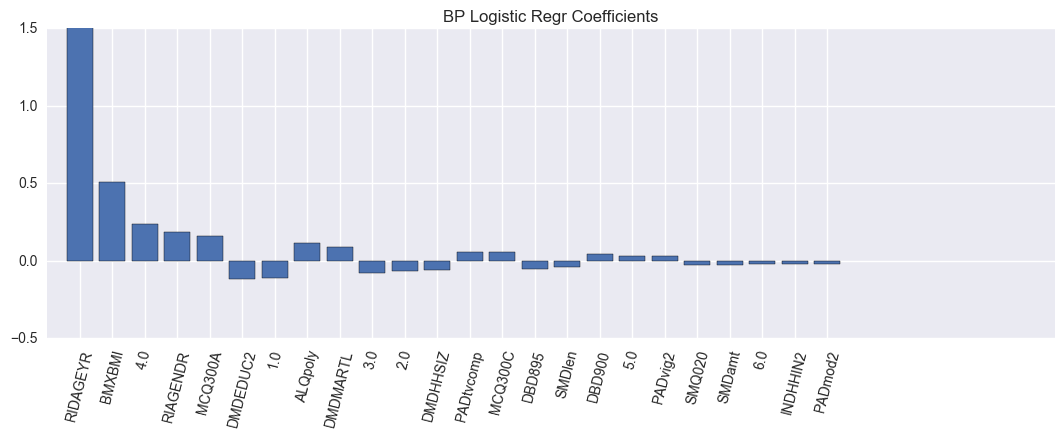

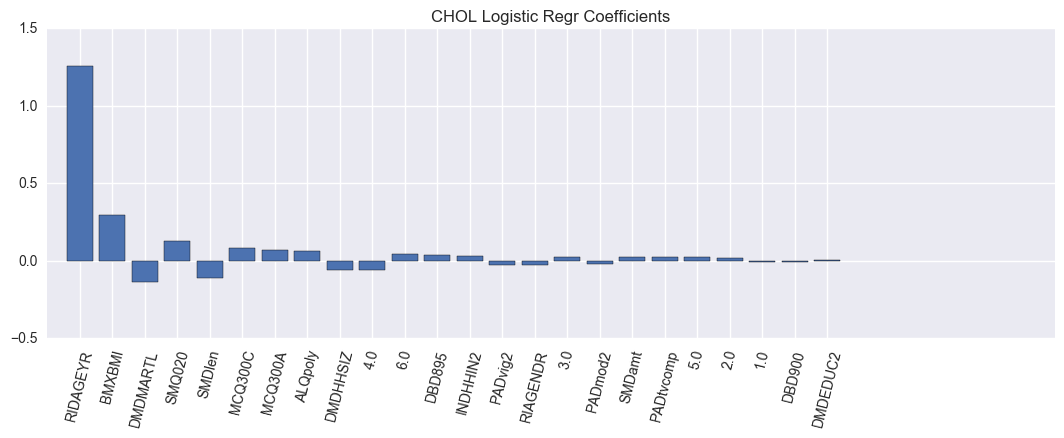

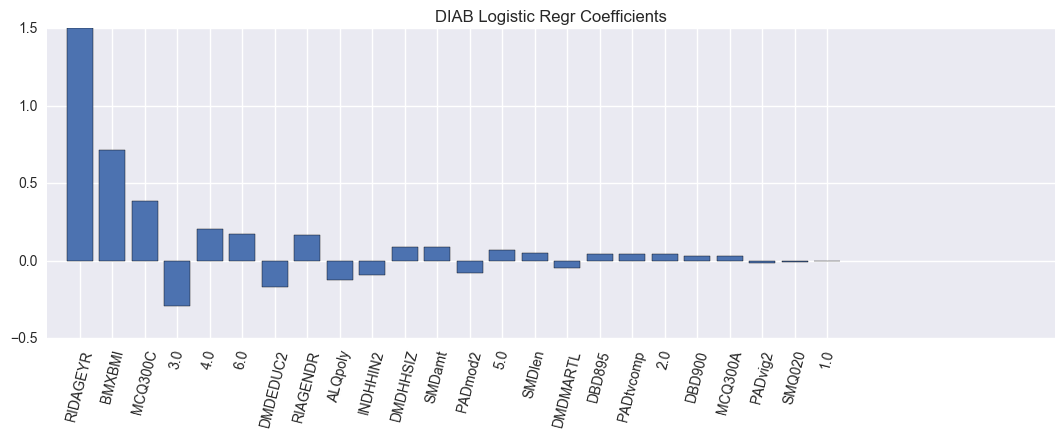

In [242]:
# look at the coefficents from the logistic regressor trained by grid_search
BPcoefs = (BPgrid_search.best_estimator_.steps[1][1].coef_); BPcoefs = np.transpose(BPcoefs); features = X1.columns; features = features.tolist(); i=0; BPcoefdict={}
for each in BPcoefs:
    if abs(each) > 0.0001:
        BPcoefdict[features[i]] = each 
    i+=1        
BPabsvalues = sorted(BPcoefdict.values(), key=abs, reverse=True); BPabskeys = []
for each in BPabsvalues:
    for eachkey in BPcoefdict.keys():
        if BPcoefdict[eachkey] == each:
            BPabskeys.append(eachkey); continue            

plt.figure(figsize=(13,4))
plt.bar(range(len(BPcoefdict)), BPabsvalues, align='center')
plt.xticks(range(len(BPcoefdict)), BPabskeys, rotation=76)
plt.xlim(-1,30); plt.ylim(-0.5,1.5); plt.title("BP Logistic Regr Coefficients"); plt.show()

# Cholesterol
CHOLcoefs = (CHOLgrid_search.best_estimator_.steps[1][1].coef_); CHOLcoefs = np.transpose(CHOLcoefs); features = X1.columns; features = features.tolist(); i=0; CHOLcoefdict={}
for each in CHOLcoefs:
    if abs(each) > 0.0001:
        CHOLcoefdict[features[i]] = each 
    i+=1        
CHOLabsvalues = sorted(CHOLcoefdict.values(), key=abs, reverse=True); CHOLabskeys = []
for each in CHOLabsvalues:
    for eachkey in CHOLcoefdict.keys():
        if CHOLcoefdict[eachkey] == each:
            CHOLabskeys.append(eachkey); continue            

plt.figure(figsize=(13,4))
plt.bar(range(len(CHOLcoefdict)), CHOLabsvalues, align='center')
plt.xticks(range(len(CHOLcoefdict)), CHOLabskeys, rotation=76)
plt.xlim(-1,30); plt.ylim(-0.5,1.5); plt.title("CHOL Logistic Regr Coefficients"); plt.show()

# look at the coefficents from the logistic regressor trained by grid_search
DIABcoefs = (DIABgrid_search.best_estimator_.steps[1][1].coef_); DIABcoefs = np.transpose(DIABcoefs); features = X1.columns; features = features.tolist(); i=0; DIABcoefdict={}
for each in DIABcoefs:
    if abs(each) > 0.0001:
        DIABcoefdict[features[i]] = each 
    i+=1        
DIABabsvalues = sorted(DIABcoefdict.values(), key=abs, reverse=True); DIABabskeys = []
for each in DIABabsvalues:
    for eachkey in DIABcoefdict.keys():
        if DIABcoefdict[eachkey] == each:
            DIABabskeys.append(eachkey); continue            

plt.figure(figsize=(13,4))
plt.bar(range(len(DIABcoefdict)), DIABabsvalues, align='center')
plt.xticks(range(len(DIABcoefdict)), DIABabskeys, rotation=76)
plt.xlim(-1,30); plt.ylim(-0.5,1.5); plt.title("DIAB Logistic Regr Coefficients"); plt.show()

### Construct ROC curves to evaluate model performance:

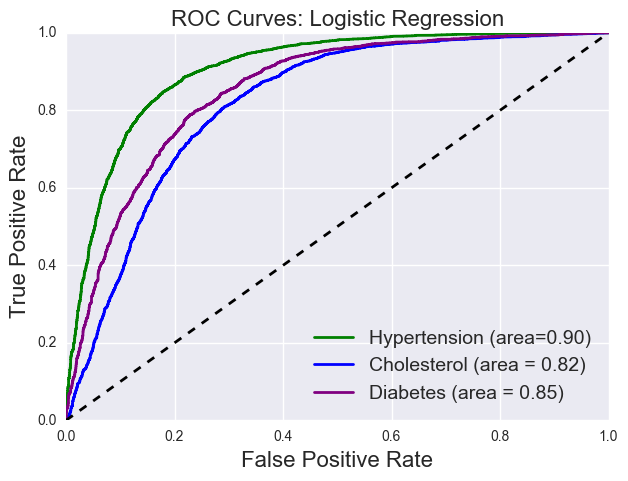

In [245]:
plt.figure(figsize=(7,5))
Aprobas_1 = BPgrid_search.best_estimator_.predict_proba(X1_test)
fpr, tpr, thresholds = roc_curve(Y1_test, Aprobas_1[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='green', label='Hypertension (area=%0.2f)' % (roc_auc))
Aprobas_2 = CHOLgrid_search.best_estimator_.predict_proba(X2_test)
fpr, tpr, thresholds = roc_curve(Y2_test, Aprobas_2[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='Cholesterol (area = %0.2f)' % (roc_auc))
Aprobas_3 = DIABgrid_search.best_estimator_.predict_proba(X3_test)
fpr, tpr, thresholds = roc_curve(Y3_test, Aprobas_3[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='purple', label='Diabetes (area = %0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k')
plt.title("ROC Curves: Logistic Regression", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16); plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(loc=4, fontsize=14); plt.show()

In [ ]:
# pickle scalers and models for incorporating into web-app:

#joblib.dump(BPgrid_search.best_estimator_.steps[0][1], 'BPscaler.pkl')
#joblib.dump(CHOLgrid_search.best_estimator_.steps[0][1], 'CHOLscaler.pkl')
#joblib.dump(DIABgrid_search.best_estimator_.steps[0][1], 'DIABscaler.pkl')
#joblib.dump(BPgrid_search.best_estimator_.steps[1][1], 'BPmodel.pkl')
#joblib.dump(CHOLgrid_search.best_estimator_.steps[1][1], 'CHOLmodel.pkl')
#joblib.dump(DIABgrid_search.best_estimator_.steps[1][1], 'DIABmodel.pkl')

# Random Forest Classification

In [246]:
# build pipelines gridsearch
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA()
randF = RandomForestClassifier(n_estimators=25)

BPestimators = [('BPscaler', scaler), ('BPrandF', randF)]
BPpipe = Pipeline(BPestimators)

CHOLestimators = [('CHOLscaler', scaler), ('CHOLrandF', randF)]
CHOLpipe = Pipeline(CHOLestimators)

DIABestimators = [('DIABscaler', scaler), ('DIABrandF', randF)]
DIABpipe = Pipeline(DIABestimators)

# implement a pipeline to split the data, transform with StandardScaler, 
# then perform gridsearch over regularization parameters
BPparams = dict(BPrandF__max_depth=[6, 9, 12], BPrandF__min_samples_split=[3, 6, 12])
CHOLparams = dict(CHOLrandF__max_depth=[6, 9, 12], CHOLrandF__min_samples_split=[3, 6, 12])
DIABparams = dict(DIABrandF__max_depth=[6, 9, 12], DIABrandF__min_samples_split=[3, 6, 12])

BPgrid_searchRF = GridSearchCV(BPpipe, param_grid=BPparams, cv=5)
CHOLgrid_searchRF = GridSearchCV(CHOLpipe, param_grid=CHOLparams, cv=5)
DIABgrid_searchRF = GridSearchCV(DIABpipe, param_grid=DIABparams, cv=5)

In [247]:
# split XY1/2/3 into training sets and test sets, perform grid search and evaluate best model on test set

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1,test_size=0.25, random_state=25)

BPgrid_searchRF.fit(X1_train, Y1_train)
means = BPgrid_searchRF.cv_results_['mean_test_score']
stds = BPgrid_searchRF.cv_results_['std_test_score']
print ("BP gridsearchRF scores:  ")
for mean, std, params in zip(means, stds, BPgrid_searchRF.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print ("BP train:  ", BPgrid_searchRF.score(X1_train, Y1_train))
print ("BP test:  ", BPgrid_searchRF.score(X1_test, Y1_test)); print()

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2,Y2,test_size=0.25, random_state=25)

CHOLgrid_searchRF.fit(X2_train, Y2_train)
means = CHOLgrid_searchRF.cv_results_['mean_test_score']
stds = CHOLgrid_searchRF.cv_results_['std_test_score']
print ("CHOL gridsearchRF scores:  ")
for mean, std, params in zip(means, stds, CHOLgrid_searchRF.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print ("CHOL train:  ", CHOLgrid_searchRF.score(X2_train, Y2_train))
print ("CHOL test:  ", CHOLgrid_searchRF.score(X2_test, Y2_test)); print()

X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3,Y3,test_size=0.25, random_state=25)

DIABgrid_searchRF.fit(X3_train, Y3_train)
means = DIABgrid_searchRF.cv_results_['mean_test_score']
stds = DIABgrid_searchRF.cv_results_['std_test_score']
print ("DIAB gridsearchRF scores:  ")
for mean, std, params in zip(means, stds, DIABgrid_searchRF.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print ("DIAB train:  ", DIABgrid_searchRF.score(X3_train, Y3_train))
print ("DIAB test:  ", DIABgrid_searchRF.score(X3_test, Y3_test))

BP gridsearchRF scores:  
0.832 (+/-0.011) for {'BPrandF__max_depth': 6, 'BPrandF__min_samples_split': 3}
0.832 (+/-0.011) for {'BPrandF__max_depth': 6, 'BPrandF__min_samples_split': 6}
0.832 (+/-0.012) for {'BPrandF__max_depth': 6, 'BPrandF__min_samples_split': 12}
0.834 (+/-0.012) for {'BPrandF__max_depth': 9, 'BPrandF__min_samples_split': 3}
0.833 (+/-0.013) for {'BPrandF__max_depth': 9, 'BPrandF__min_samples_split': 6}
0.835 (+/-0.010) for {'BPrandF__max_depth': 9, 'BPrandF__min_samples_split': 12}
0.834 (+/-0.012) for {'BPrandF__max_depth': 12, 'BPrandF__min_samples_split': 3}
0.833 (+/-0.011) for {'BPrandF__max_depth': 12, 'BPrandF__min_samples_split': 6}
0.835 (+/-0.012) for {'BPrandF__max_depth': 12, 'BPrandF__min_samples_split': 12}
BP train:   0.87549862763
BP test:   0.82928971347

CHOL gridsearchRF scores:  
0.758 (+/-0.006) for {'CHOLrandF__max_depth': 6, 'CHOLrandF__min_samples_split': 3}
0.757 (+/-0.004) for {'CHOLrandF__max_depth': 6, 'CHOLrandF__min_samples_split': 6}


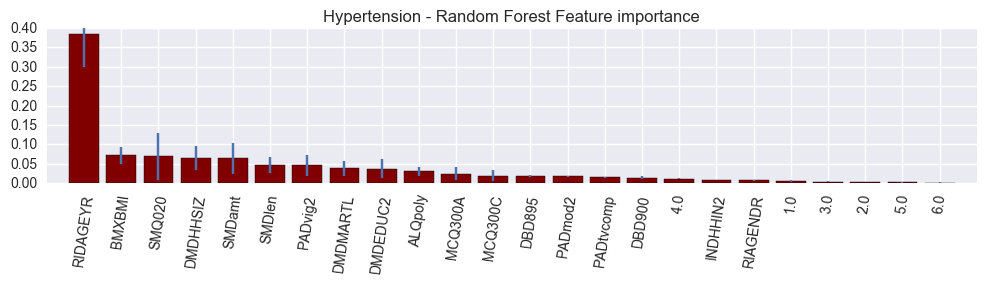

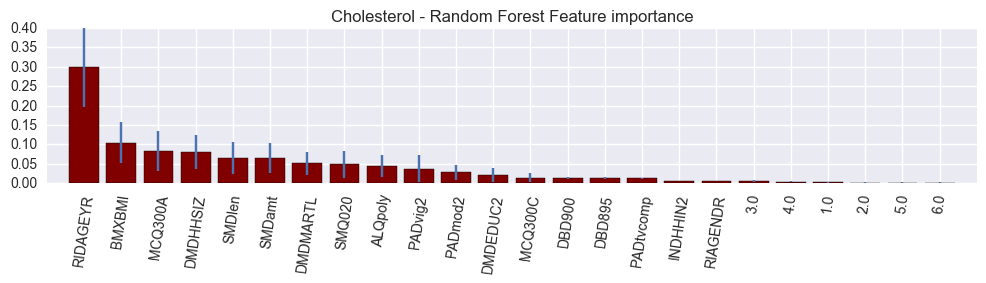

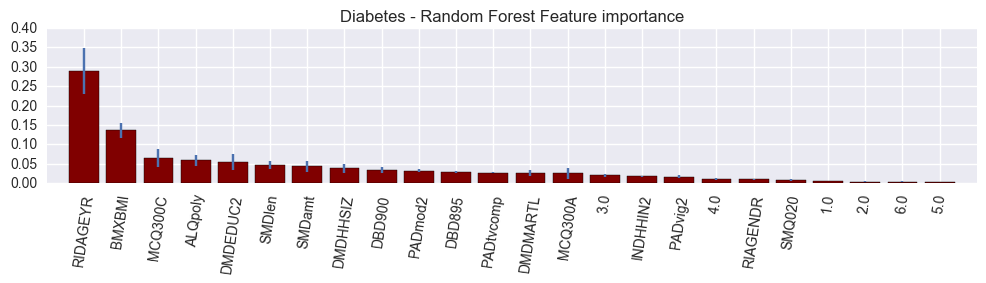

In [251]:
importances = BPgrid_searchRF.best_estimator_.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in BPgrid_searchRF.best_estimator_.steps[1][1].estimators_],axis=0); indices = np.argsort(importances)[::-1]
labels = []
for each in indices:
    labels.append(list(X1)[each])

plt.figure(figsize=(12,2)); plt.title("Hypertension - Random Forest Feature importance")
plt.bar(range(X1.shape[1]), importances[indices], color="maroon", yerr=(std[indices]/2), align="center")
plt.xticks(range(X1.shape[1]), labels, rotation=82); plt.xlim([-1, X1.shape[1]]); plt.ylim([0, 0.4])
plt.show()

importances = CHOLgrid_searchRF.best_estimator_.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in CHOLgrid_searchRF.best_estimator_.steps[1][1].estimators_],axis=0); indices = np.argsort(importances)[::-1]
labels = []
for each in indices:
    labels.append(list(X1)[each])

plt.figure(figsize=(12,2)); plt.title("Cholesterol - Random Forest Feature importance")
plt.bar(range(X1.shape[1]), importances[indices], color="maroon", yerr=(std[indices]/2), align="center")
plt.xticks(range(X1.shape[1]), labels, rotation=82); plt.xlim([-1, X1.shape[1]]); plt.ylim([0, 0.4])
plt.show()

importances = DIABgrid_searchRF.best_estimator_.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in DIABgrid_searchRF.best_estimator_.steps[1][1].estimators_],axis=0); indices = np.argsort(importances)[::-1]
labels = []
for each in indices:
    labels.append(list(X1)[each])

plt.figure(figsize=(12,2)); plt.title("Diabetes - Random Forest Feature importance")
plt.bar(range(X1.shape[1]), importances[indices], color="maroon", yerr=(std[indices]/2), align="center")
plt.xticks(range(X1.shape[1]), labels, rotation=82); plt.xlim([-1, X1.shape[1]]); plt.ylim([0, 0.4])
plt.show()

## Construct ROC curves to evaluate model performance

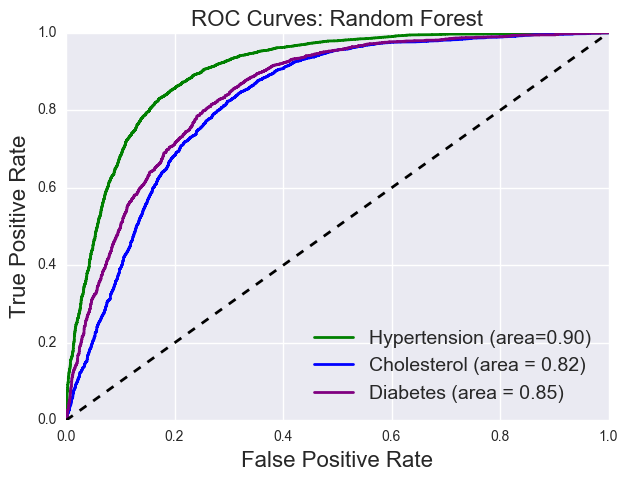

In [252]:
plt.figure(figsize=(7,5))
Aprobas_1 = BPgrid_searchRF.best_estimator_.predict_proba(X1_test)
fpr, tpr, thresholds = roc_curve(Y1_test, Aprobas_1[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='green', label='Hypertension (area=%0.2f)' % (roc_auc))
Aprobas_2 = CHOLgrid_searchRF.best_estimator_.predict_proba(X2_test)
fpr, tpr, thresholds = roc_curve(Y2_test, Aprobas_2[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='Cholesterol (area = %0.2f)' % (roc_auc))
Aprobas_3 = DIABgrid_searchRF.best_estimator_.predict_proba(X3_test)
fpr, tpr, thresholds = roc_curve(Y3_test, Aprobas_3[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='purple', label='Diabetes (area = %0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k')
plt.title("ROC Curves: Random Forest", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16); plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(loc=4, fontsize=14); plt.show()

# Gradient Boosting (Tree) Classificaiton

In [253]:
# build pipelines gridsearch
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA()
gbc = GradientBoostingClassifier(n_estimators=25)

BPestimators = [('BPscaler', scaler), ('BPgbc', gbc)]
BPpipe = Pipeline(BPestimators)

CHOLestimators = [('CHOLscaler', scaler), ('CHOLgbc', gbc)]
CHOLpipe = Pipeline(CHOLestimators)

DIABestimators = [('DIABscaler', scaler), ('DIABgbc', gbc)]
DIABpipe = Pipeline(DIABestimators)

# implement a pipeline to split the data, transform with StandardScaler, 
# then perform gridsearch over regularization parameters
BPparams = dict(BPgbc__max_depth=[6, 12], BPgbc__min_samples_split=[6])
CHOLparams = dict(CHOLgbc__max_depth=[6, 12], CHOLgbc__min_samples_split=[6])
DIABparams = dict(DIABgbc__max_depth=[6, 12], DIABgbc__min_samples_split=[6])

BPgrid_searchGB = GridSearchCV(BPpipe, param_grid=BPparams, cv=5)
CHOLgrid_searchGB = GridSearchCV(CHOLpipe, param_grid=CHOLparams, cv=5)
DIABgrid_searchGB = GridSearchCV(DIABpipe, param_grid=DIABparams, cv=5)

In [254]:
# split XY1/2/3 into training sets and test sets, peGBorm grid search and evaluate best model on test set

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1,test_size=0.25, random_state=25)

BPgrid_searchGB.fit(X1_train, Y1_train)
means = BPgrid_searchGB.cv_results_['mean_test_score']
stds = BPgrid_searchGB.cv_results_['std_test_score']
print ("BP gridsearchGB scores:  ")
for mean, std, params in zip(means, stds, BPgrid_searchGB.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print ("BP train:  ", BPgrid_searchGB.score(X1_train, Y1_train))
print ("BP test:  ", BPgrid_searchGB.score(X1_test, Y1_test)); print()

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2,Y2,test_size=0.25, random_state=25)

CHOLgrid_searchGB.fit(X2_train, Y2_train)
means = CHOLgrid_searchGB.cv_results_['mean_test_score']
stds = CHOLgrid_searchGB.cv_results_['std_test_score']
print ("CHOL gridsearchGB scores:  ")
for mean, std, params in zip(means, stds, CHOLgrid_searchGB.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print ("CHOL train:  ", CHOLgrid_searchGB.score(X2_train, Y2_train))
print ("CHOL test:  ", CHOLgrid_searchGB.score(X2_test, Y2_test)); print()

X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3,Y3,test_size=0.25, random_state=25)

DIABgrid_searchGB.fit(X3_train, Y3_train)
means = DIABgrid_searchGB.cv_results_['mean_test_score']
stds = DIABgrid_searchGB.cv_results_['std_test_score']
print ("DIAB gridsearchGB scores:  ")
for mean, std, params in zip(means, stds, DIABgrid_searchGB.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print ("DIAB train:  ", DIABgrid_searchGB.score(X3_train, Y3_train))
print ("DIAB test:  ", DIABgrid_searchGB.score(X3_test, Y3_test))

BP gridsearchGB scores:  
0.837 (+/-0.010) for {'BPgbc__min_samples_split': 6, 'BPgbc__max_depth': 6}
0.823 (+/-0.009) for {'BPgbc__min_samples_split': 6, 'BPgbc__max_depth': 12}
BP train:   0.850430009149
BP test:   0.832692941047

CHOL gridsearchGB scores:  
0.763 (+/-0.008) for {'CHOLgbc__max_depth': 6, 'CHOLgbc__min_samples_split': 6}
0.750 (+/-0.008) for {'CHOLgbc__max_depth': 12, 'CHOLgbc__min_samples_split': 6}
CHOL train:   0.789393519801
CHOL test:   0.765300470784

DIAB gridsearchGB scores:  
0.787 (+/-0.009) for {'DIABgbc__min_samples_split': 6, 'DIABgbc__max_depth': 6}
0.768 (+/-0.017) for {'DIABgbc__min_samples_split': 6, 'DIABgbc__max_depth': 12}
DIAB train:   0.820934781143
DIAB test:   0.782723042687


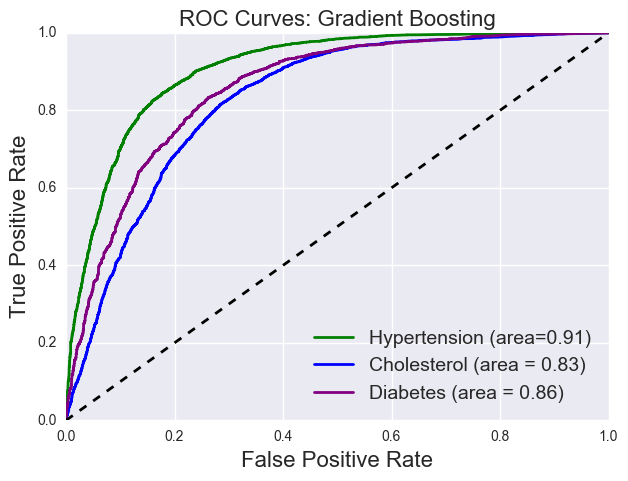

In [255]:
plt.figure(figsize=(7,5))
Aprobas_1 = BPgrid_searchGB.best_estimator_.predict_proba(X1_test)
fpr, tpr, thresholds = roc_curve(Y1_test, Aprobas_1[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='green', label='Hypertension (area=%0.2f)' % (roc_auc))
Aprobas_2 = CHOLgrid_searchGB.best_estimator_.predict_proba(X2_test)
fpr, tpr, thresholds = roc_curve(Y2_test, Aprobas_2[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='Cholesterol (area = %0.2f)' % (roc_auc))
Aprobas_3 = DIABgrid_searchGB.best_estimator_.predict_proba(X3_test)
fpr, tpr, thresholds = roc_curve(Y3_test, Aprobas_3[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='purple', label='Diabetes (area = %0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k')
plt.title("ROC Curves: Gradient Boosting", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16); plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(loc=4, fontsize=14); plt.show()

## Compare Logistic Regression, Random Forest, and Gradient Boosting

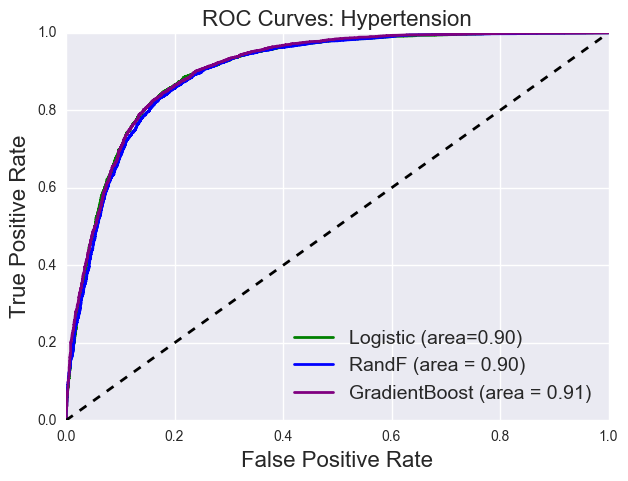

In [261]:
plt.figure(figsize=(7,5))
Aprobas_1 = BPgrid_search.best_estimator_.predict_proba(X1_test)
fpr, tpr, thresholds = roc_curve(Y1_test, Aprobas_1[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='green', label='Logistic (area=%0.2f)' % (roc_auc))
Aprobas_2 = BPgrid_searchRF.best_estimator_.predict_proba(X1_test)
fpr, tpr, thresholds = roc_curve(Y1_test, Aprobas_2[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='RandF (area = %0.2f)' % (roc_auc))
Aprobas_3 = BPgrid_searchGB.best_estimator_.predict_proba(X1_test)
fpr, tpr, thresholds = roc_curve(Y1_test, Aprobas_3[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='purple', label='GradientBoost (area = %0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k')
plt.title("ROC Curves: Hypertension", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16); plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(loc=4, fontsize=14); plt.show()

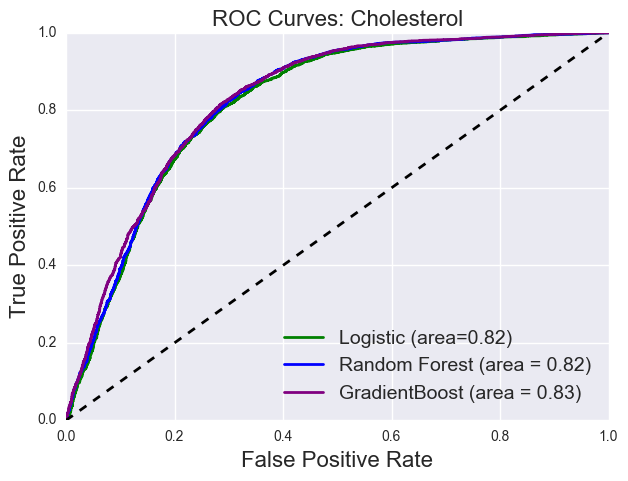

In [260]:
plt.figure(figsize=(7,5))
Aprobas_1 = CHOLgrid_search.best_estimator_.predict_proba(X2_test)
fpr, tpr, thresholds = roc_curve(Y2_test, Aprobas_1[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='green', label='Logistic (area=%0.2f)' % (roc_auc))
Aprobas_2 = CHOLgrid_searchRF.best_estimator_.predict_proba(X2_test)
fpr, tpr, thresholds = roc_curve(Y2_test, Aprobas_2[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='Random Forest (area = %0.2f)' % (roc_auc))
Aprobas_3 = CHOLgrid_searchGB.best_estimator_.predict_proba(X2_test)
fpr, tpr, thresholds = roc_curve(Y2_test, Aprobas_3[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='purple', label='GradientBoost (area = %0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k')
plt.title("ROC Curves: Cholesterol", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16); plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(loc=4, fontsize=14); plt.show()

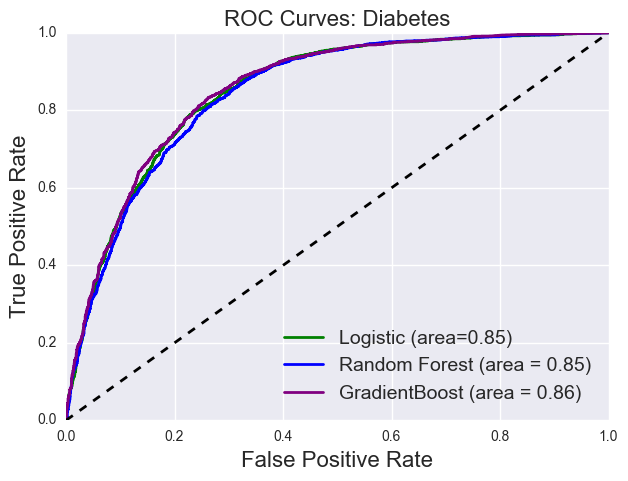

In [259]:
plt.figure(figsize=(7,5))
Aprobas_1 = DIABgrid_search.best_estimator_.predict_proba(X3_test)
fpr, tpr, thresholds = roc_curve(Y3_test, Aprobas_1[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='green', label='Logistic (area=%0.2f)' % (roc_auc))
Aprobas_2 = DIABgrid_searchRF.best_estimator_.predict_proba(X3_test)
fpr, tpr, thresholds = roc_curve(Y3_test, Aprobas_2[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='Random Forest (area = %0.2f)' % (roc_auc))
Aprobas_3 = DIABgrid_searchGB.best_estimator_.predict_proba(X3_test)
fpr, tpr, thresholds = roc_curve(Y3_test, Aprobas_3[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='purple', label='GradientBoost (area = %0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k')
plt.title("ROC Curves: Diabetes", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16); plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(loc=4, fontsize=14); plt.show()

## Some more feature exploration...

#### Here we set up a pipeline for visualizing a given feature's correlation with a given target variable stratified by age:

In [262]:
# split XY data based on target
XY2_chol = XY2[XY2[target] == 1.0]
XY2_un = XY2[XY2[target] == 0.0]

# and collect the mean of a target parameter for a given age in each category
ymean_pos = []
for each in range(10,80):
    ymean_pos.append(XY2_chol[XY2_chol['RIDAGEYR'] == each].ALQpoly.mean())
ymean_neg = []
for each in range(10,80):
    ymean_neg.append(XY2_un[XY2_un['RIDAGEYR'] == each].ALQpoly.mean())

In [263]:
# convert the yearly average from age 10 to 80 into a more interpretable 10-year decade average:
decade_pos = []
for each in range(7):
    decade_pos.append(np.mean(np.asarray(ymean_pos[10*each:10*each+10])))
decade_neg = []
for each in range(7):
    decade_neg.append(np.mean(np.asarray(ymean_neg[10*each:10*each+10])))
decade_posstd = []
for each in range(7):
    decade_posstd.append((np.std(np.asarray(ymean_pos[10*each:10*each+10]))/10**.5))
decade_negstd = []
for each in range(7):
    decade_negstd.append((np.std(np.asarray(ymean_neg[10*each:10*each+10]))/10**.5))

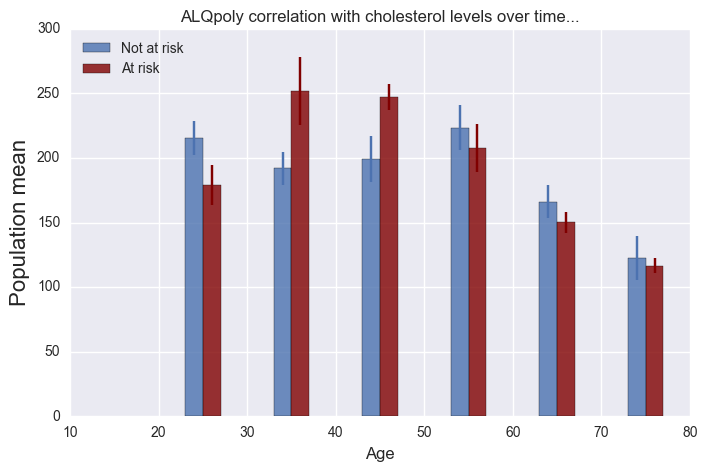

In [266]:
# plot the decade average for each condition
plt.figure(figsize=(8,5))
plt.bar([13,23,33,43,53,63,73], decade_neg, label='Not at risk', alpha=0.8, width=2, yerr=decade_negstd)
plt.bar([15,25,35,45,55,65,75], decade_pos, label='At risk', color='maroon', alpha=0.8, width=2, yerr=decade_posstd, error_kw=dict(ecolor='maroon'))
plt.legend(loc='upper left')
plt.xlabel("Age", fontsize=12); plt.ylabel("Population mean", fontsize=16)
plt.xlim(10,80); plt.title('ALQpoly correlation with cholesterol levels over time...')
plt.show()